This notebook is a notebook which aims to generate a very generalized N-of-1 trial and test how it could be extended through adaptivity.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Setup generic n-of-1 parameters

### Supposed to be based on this, but not yet
### Based on "N-of-1 trials in the medical literature: a systematic review"

length = 10
number_of_actions = 2
number_of_patients = 100

In [59]:
import numpy
from adaptive_nof1.models import Model
from adaptive_nof1.basic_types import Outcome

RED_PILL = 0
BLUE_PILL = 1


class PillModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.red_pill_slope = self.rng.normal(0, 1)
        self.patient_id = patient_id

    def generate_context(self, history):
        return {}

    def observe_outcome(self, action, context):
        if action["treatment"] == RED_PILL:
            return {"outcome": self.rng.normal(1, 1)}
        else:
            return {"outcome": self.rng.normal(-1, 1)}

    def __str__(self):
        return f"PillModel"


data_generating_model = lambda patient_id: PillModel(patient_id)

In [60]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.inference import ConjugateNormalModel
from adaptive_nof1.policies import (
    FixedPolicy,
    FrequentistEpsilonGreedy,
    ConstantPolicy,
    ThompsonSampling,
)

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedPolicy(number_of_actions=number_of_actions),
)

adaptive_series_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=ThompsonSampling(
        number_of_actions=number_of_actions,
        inference_model=ConjugateNormalModel(l=10.0, alpha=10, beta=10, mean=0),
    ),
)

fixed_schedule_data = fixed_schedule_runner.simulate(length)
adaptive_series_data = adaptive_series_runner.simulate(length)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='t', ylabel='Regret'>

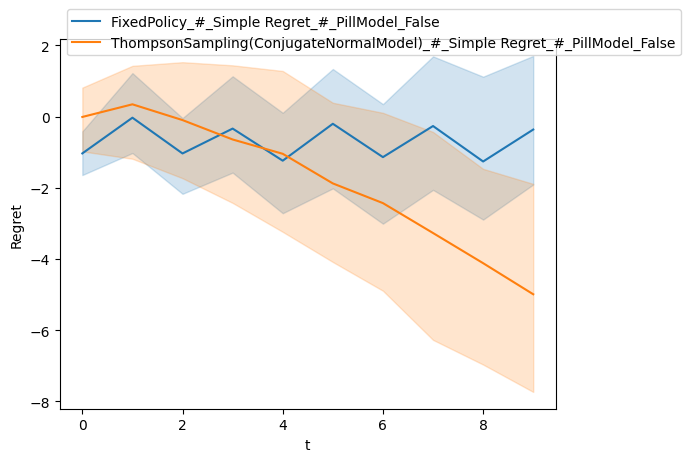

In [61]:
from adaptive_nof1.metrics import SimpleRegret
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

SeriesOfSimulationsData.plot_lines(
    [fixed_schedule_data, adaptive_series_data],
    [SimpleRegret()],
)

In [63]:
adaptive_series_data.plot_allocations()

:HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)

There are many more policies, metrics, and models to explore. You can find an overview in the respective '\_\_init__.py' files in the folders, which include the different policies.

# Possible scenarios:
- extend trial length while keeping regret (increasing simple regret, BAI)
- testing more medications in the same time
- creating more certainty in shorter time